In [1]:
# ============================================================================
# 1. SETUP AND IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")
print("=" * 80)

All libraries imported successfully!


In [2]:
# ============================================================================
# 2. DATASET GENERATION
# ============================================================================

def generate_synthetic_dataset(n_samples=1000, random_state=42):
    """
    Generate a synthetic dataset for event affordability analysis
    """
    np.random.seed(random_state)

    # Define event types and their typical price ranges
    event_types = ['Concert', 'Sports', 'Festival', 'Seminar', 'Exhibition']
    event_price_ranges = {
        'Concert': (50, 200),
        'Sports': (30, 150),
        'Festival': (20, 100),
        'Seminar': (100, 300),
        'Exhibition': (40, 120)
    }

    # Generate demographic data
    ages = np.random.randint(18, 66, n_samples)
    genders = np.random.choice(['Male', 'Female', 'Other'], n_samples, p=[0.48, 0.48, 0.04])

    # Generate income with realistic distribution (log-normal)
    incomes = np.random.lognormal(mean=10.5, sigma=0.6, size=n_samples)
    incomes = np.clip(incomes, 20000, 200000).astype(int)

    # Generate event preferences with some correlation to income and age
    event_type_list = []
    ticket_prices = []

    for i in range(n_samples):
        # Younger people prefer concerts and festivals
        # Older people prefer seminars and exhibitions
        if ages[i] < 30:
            event_probs = [0.35, 0.25, 0.25, 0.05, 0.10]
        elif ages[i] < 45:
            event_probs = [0.25, 0.30, 0.15, 0.15, 0.15]
        else:
            event_probs = [0.15, 0.20, 0.10, 0.30, 0.25]

        event = np.random.choice(event_types, p=event_probs)
        event_type_list.append(event)

        # Generate ticket price within event range
        price_range = event_price_ranges[event]
        base_price = np.random.uniform(price_range[0], price_range[1])
        ticket_prices.append(round(base_price, 2))

    # Generate attendance based on affordability
    affordability_ratio = incomes / np.array(ticket_prices)
    attendance_prob = 1 / (1 + np.exp(-0.01 * (affordability_ratio - 50)))
    attendance = (np.random.random(n_samples) < attendance_prob).astype(int)

    # Create DataFrame
    df = pd.DataFrame({
        'Age': ages,
        'Gender': genders,
        'Income': incomes,
        'Event_Type': event_type_list,
        'Ticket_Price': ticket_prices,
        'Attendance': attendance
    })

    return df

# Generate the dataset
print("\n" + "=" * 80)
print("GENERATING SYNTHETIC DATASET")
print("=" * 80)

df = generate_synthetic_dataset(n_samples=1000, random_state=42)
print(f"\nDataset created with {len(df)} samples")
print("\nFirst 10 rows:")
print(df.head(10))


GENERATING SYNTHETIC DATASET

Dataset created with 1000 samples

First 10 rows:
   Age  Gender  Income  Event_Type  Ticket_Price  Attendance
0   56  Female   20000      Sports        126.85           1
1   46    Male   30238      Sports         71.44           1
2   32    Male   25192      Sports        147.42           1
3   60  Female   32461  Exhibition         96.09           1
4   25    Male   37571    Festival         64.97           1
5   38  Female   49901  Exhibition         79.70           1
6   56    Male   34811    Festival         33.04           1
7   36  Female   48625     Seminar        246.89           1
8   40  Female   37747      Sports         33.02           1
9   28    Male   20000    Festival         20.91           1


In [3]:
# ============================================================================
# 3. DATA EXPLORATION
# ============================================================================

print("\n" + "=" * 80)
print("DATA EXPLORATION")
print("=" * 80)

print("\nDataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nValue Counts:")
print("\nGender Distribution:")
print(df['Gender'].value_counts())
print("\nEvent Type Distribution:")
print(df['Event_Type'].value_counts())
print("\nAttendance Distribution:")
print(df['Attendance'].value_counts())


DATA EXPLORATION

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           1000 non-null   int32  
 1   Gender        1000 non-null   object 
 2   Income        1000 non-null   int64  
 3   Event_Type    1000 non-null   object 
 4   Ticket_Price  1000 non-null   float64
 5   Attendance    1000 non-null   int64  
dtypes: float64(1), int32(1), int64(2), object(2)
memory usage: 43.1+ KB
None

Summary Statistics:
               Age         Income  Ticket_Price   Attendance
count  1000.000000    1000.000000   1000.000000  1000.000000
mean     41.575000   44815.599000    108.585140     0.907000
std      13.765677   27237.067524     59.056488     0.290578
min      18.000000   20000.000000     20.910000     0.000000
25%      30.000000   25144.250000     63.297500     1.000000
50%      42.000000   36682.000000     95.625000     1


GENERATING VISUALIZATIONS
✓ Saved: 01_data_distributions.png


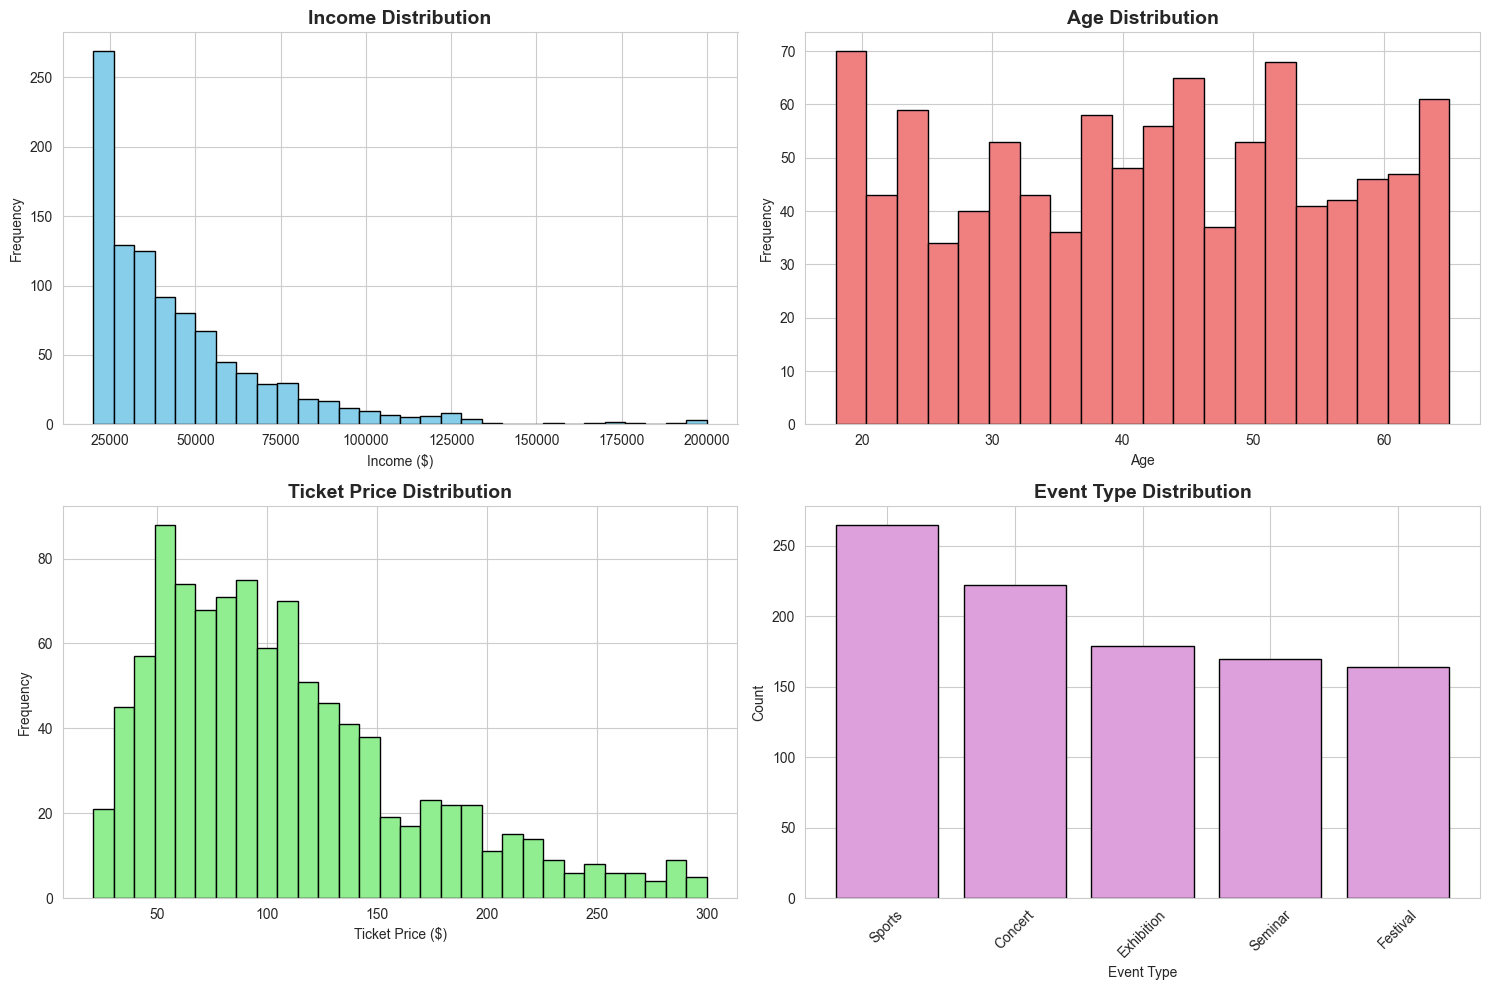

✓ Saved: 02_demographics.png


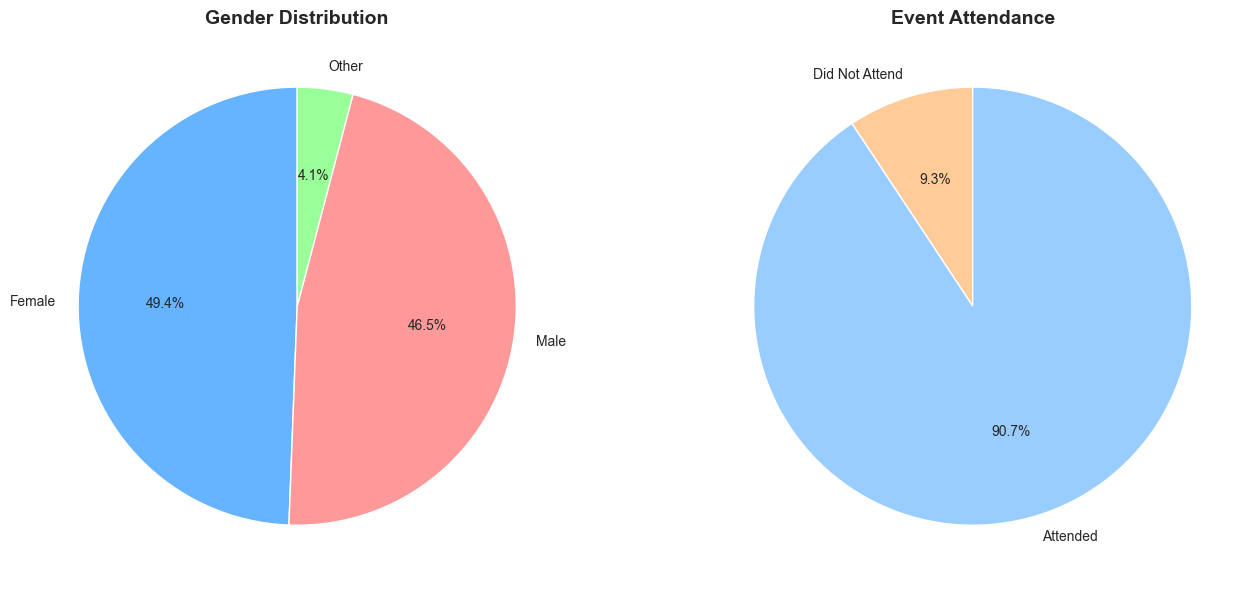

✓ Saved: 03_income_vs_price.png


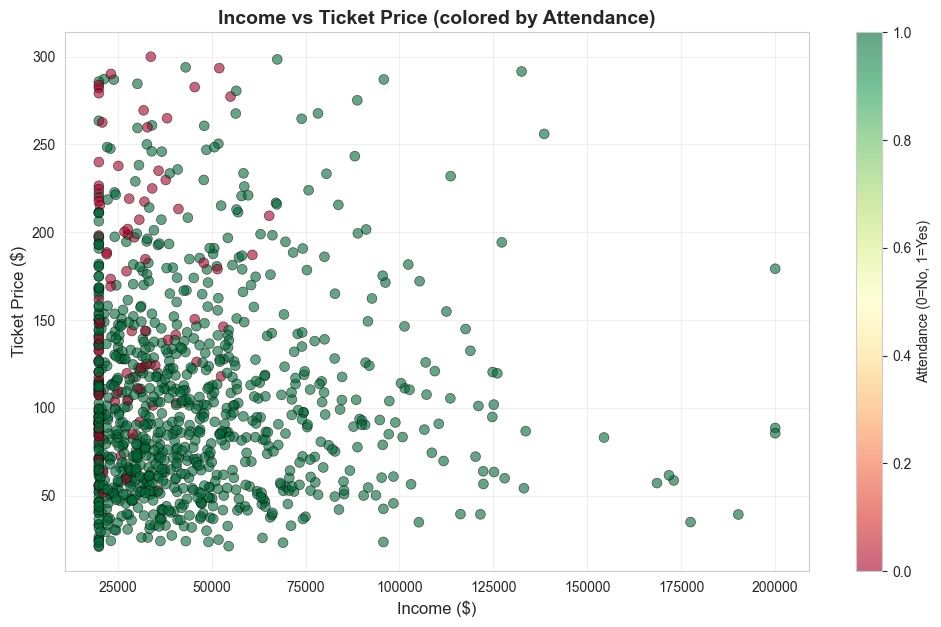

✓ Saved: 04_event_by_age.png


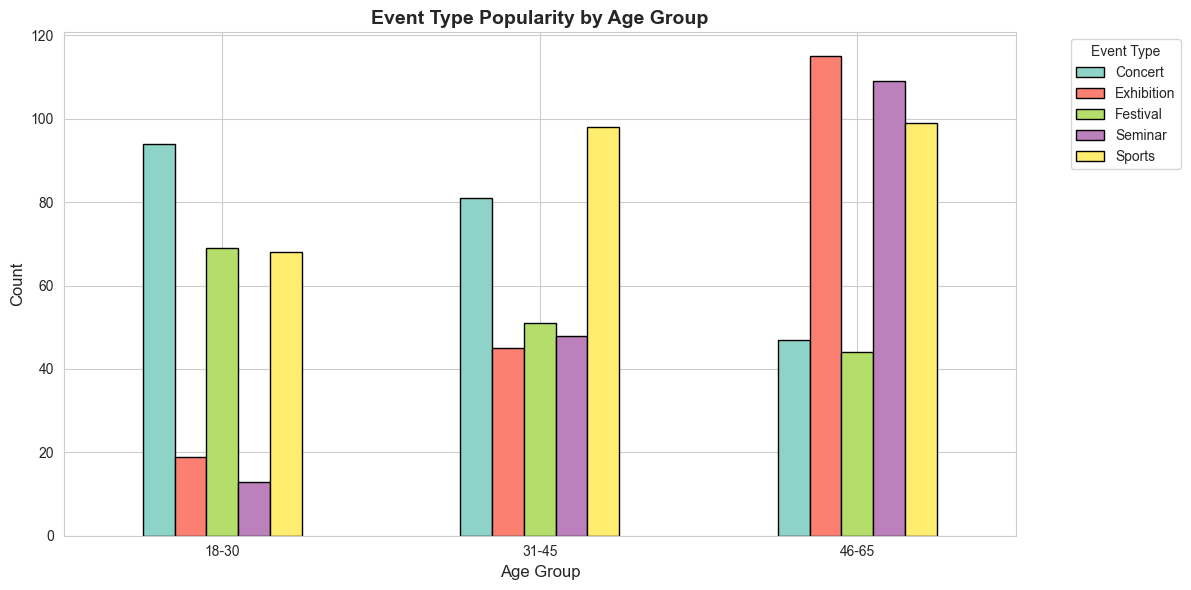

In [4]:
# ============================================================================
# 4. DATA VISUALIZATION
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING VISUALIZATIONS")
print("=" * 80)

# Figure 1: Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Income distribution
axes[0, 0].hist(df['Income'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Income Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Income ($)')
axes[0, 0].set_ylabel('Frequency')

# Age distribution
axes[0, 1].hist(df['Age'], bins=20, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Age Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Frequency')

# Ticket price distribution
axes[1, 0].hist(df['Ticket_Price'], bins=30, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Ticket Price Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Ticket Price ($)')
axes[1, 0].set_ylabel('Frequency')

# Event type distribution
event_counts = df['Event_Type'].value_counts()
axes[1, 1].bar(event_counts.index, event_counts.values, color='plum', edgecolor='black')
axes[1, 1].set_title('Event Type Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Event Type')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('01_data_distributions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 01_data_distributions.png")
plt.show()

# Figure 2: Demographics
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gender distribution pie chart
gender_counts = df['Gender'].value_counts()
axes[0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
            colors=['#66b3ff', '#ff9999', '#99ff99'], startangle=90)
axes[0].set_title('Gender Distribution', fontsize=14, fontweight='bold')

# Attendance pie chart
attendance_labels = ['Did Not Attend', 'Attended']
attendance_counts = df['Attendance'].value_counts().sort_index()
axes[1].pie(attendance_counts.values, labels=attendance_labels, autopct='%1.1f%%',
            colors=['#ffcc99', '#99ccff'], startangle=90)
axes[1].set_title('Event Attendance', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('02_demographics.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 02_demographics.png")
plt.show()

# Figure 3: Income vs Ticket Price scatter
plt.figure(figsize=(12, 7))
scatter = plt.scatter(df['Income'], df['Ticket_Price'],
                     c=df['Attendance'], cmap='RdYlGn',
                     alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Attendance (0=No, 1=Yes)')
plt.xlabel('Income ($)', fontsize=12)
plt.ylabel('Ticket Price ($)', fontsize=12)
plt.title('Income vs Ticket Price (colored by Attendance)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.savefig('03_income_vs_price.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 03_income_vs_price.png")
plt.show()

# Figure 4: Event type popularity by age group
df['Age_Group'] = pd.cut(df['Age'], bins=[17, 30, 45, 66], labels=['18-30', '31-45', '46-65'])
event_age_crosstab = pd.crosstab(df['Age_Group'], df['Event_Type'])

event_age_crosstab.plot(kind='bar', figsize=(12, 6), colormap='Set3', edgecolor='black')
plt.title('Event Type Popularity by Age Group', fontsize=14, fontweight='bold')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('04_event_by_age.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 04_event_by_age.png")
plt.show()

In [5]:
# ============================================================================
# 5. FEATURE ENGINEERING
# ============================================================================

print("\n" + "=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Create affordability index
df['Affordability_Index'] = df['Income'] / df['Ticket_Price']
print("\n✓ Created Affordability_Index = Income / Ticket_Price")

# Create budget categories based on income
income_terciles = df['Income'].quantile([0.33, 0.67])
df['Budget_Category'] = pd.cut(df['Income'],
                                bins=[0, income_terciles.iloc[0], income_terciles.iloc[1], np.inf],
                                labels=['Low', 'Medium', 'High'])
print("✓ Created Budget_Category based on income terciles")
print(f"  - Low: $0 - ${income_terciles.iloc[0]:,.0f}")
print(f"  - Medium: ${income_terciles.iloc[0]:,.0f} - ${income_terciles.iloc[1]:,.0f}")
print(f"  - High: ${income_terciles.iloc[1]:,.0f}+")

print("\nBudget Category Distribution:")
print(df['Budget_Category'].value_counts().sort_index())

# Encode categorical variables
le_gender = LabelEncoder()
le_event = LabelEncoder()
le_budget = LabelEncoder()

df['Gender_Encoded'] = le_gender.fit_transform(df['Gender'])
df['Event_Type_Encoded'] = le_event.fit_transform(df['Event_Type'])
df['Budget_Category_Encoded'] = le_budget.fit_transform(df['Budget_Category'])

print("\n✓ Encoded categorical variables")
print(f"  - Gender: {dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_)))}")
print(f"  - Event_Type: {dict(zip(le_event.classes_, le_event.transform(le_event.classes_)))}")
print(f"  - Budget_Category: {dict(zip(le_budget.classes_, le_budget.transform(le_budget.classes_)))}")

# Display enhanced dataset
print("\nEnhanced Dataset (first 5 rows):")
print(df.head())


FEATURE ENGINEERING

✓ Created Affordability_Index = Income / Ticket_Price
✓ Created Budget_Category based on income terciles
  - Low: $0 - $29,043
  - Medium: $29,043 - $48,145
  - High: $48,145+

Budget Category Distribution:
Budget_Category
Low       330
Medium    340
High      330
Name: count, dtype: int64

✓ Encoded categorical variables
  - Gender: {'Female': np.int64(0), 'Male': np.int64(1), 'Other': np.int64(2)}
  - Event_Type: {np.str_('Concert'): np.int64(0), np.str_('Exhibition'): np.int64(1), np.str_('Festival'): np.int64(2), np.str_('Seminar'): np.int64(3), np.str_('Sports'): np.int64(4)}
  - Budget_Category: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}

Enhanced Dataset (first 5 rows):
   Age  Gender  Income  Event_Type  Ticket_Price  Attendance Age_Group  \
0   56  Female   20000      Sports        126.85           1     46-65   
1   46    Male   30238      Sports         71.44           1     46-65   
2   32    Male   25192      Sports        147.42


CLUSTERING ANALYSIS (K-MEANS)
✓ Saved: 05_elbow_method.png


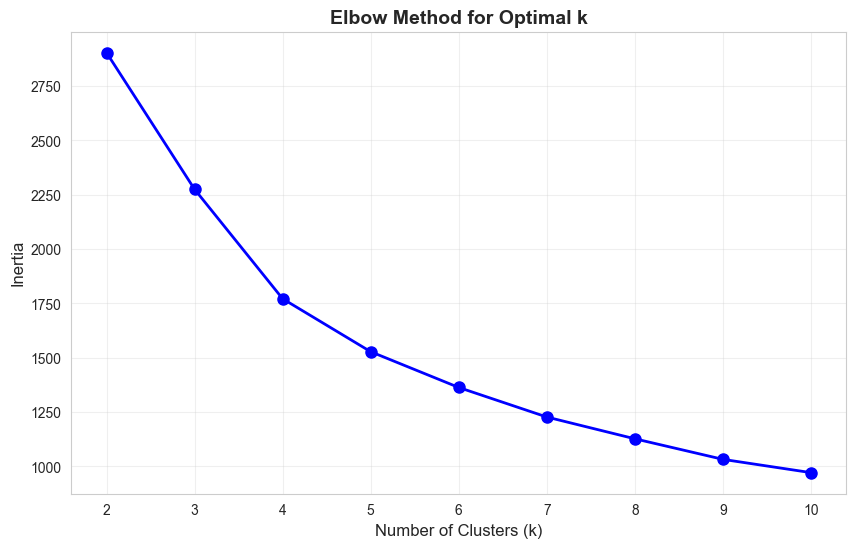


Applying K-Means with k=4...
✓ Clustering complete!

Cluster Distribution:
Cluster
0    348
1    336
2    121
3    195
Name: count, dtype: int64

Cluster Characteristics:
           Income  Ticket_Price  Affordability_Index    Age  Attendance
Cluster                                                                
0        36438.63         86.42               481.22  53.05        0.95
1        36987.34         89.78               481.15  28.43        0.91
2        94946.45         70.52              1555.19  41.87        1.00
3        42147.12        204.18               212.07  43.56        0.77

✓ Saved: 06_cluster_visualization.png


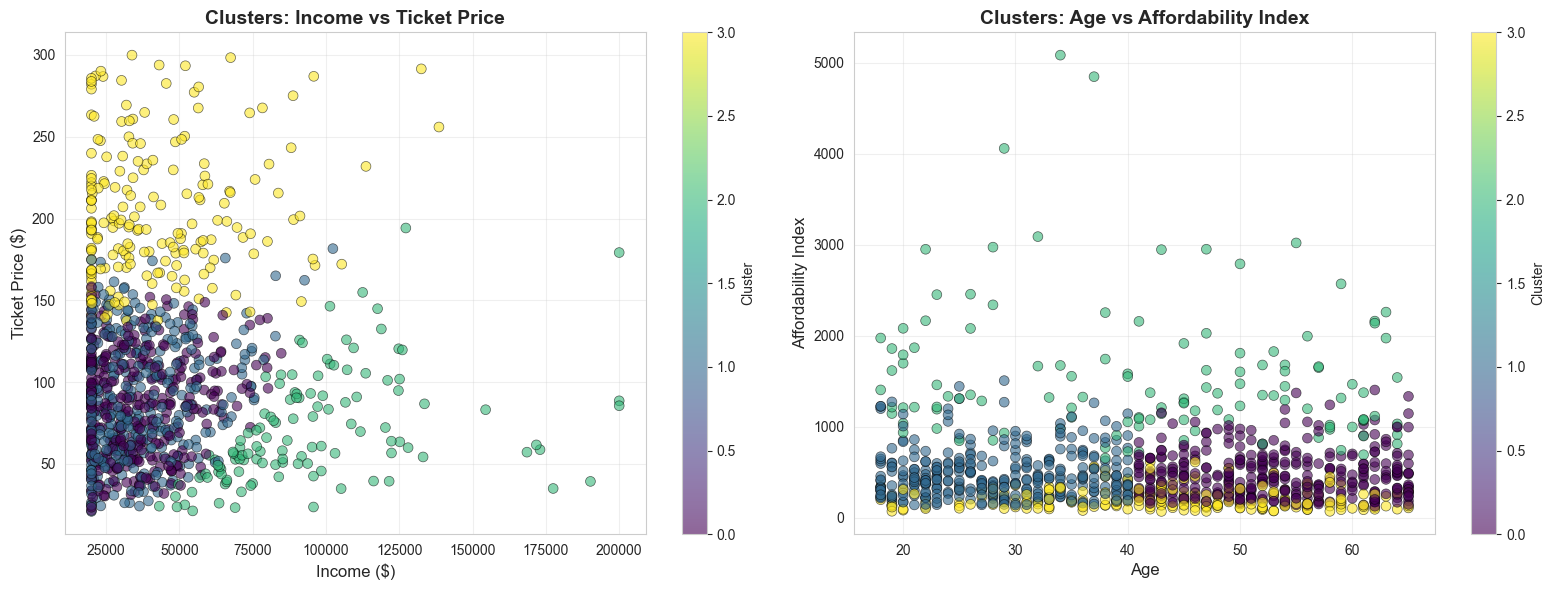


Event Type Preferences by Cluster:
Event_Type  Concert  Exhibition  Festival  Seminar  Sports
Cluster                                                   
0              12.9        32.8      13.8     10.1    30.5
1              28.9        11.0      24.1      2.4    33.6
2              12.4        23.1      28.9      4.1    31.4
3              33.3         0.0       0.0     62.6     4.1
✓ Saved: 07_cluster_event_preferences.png


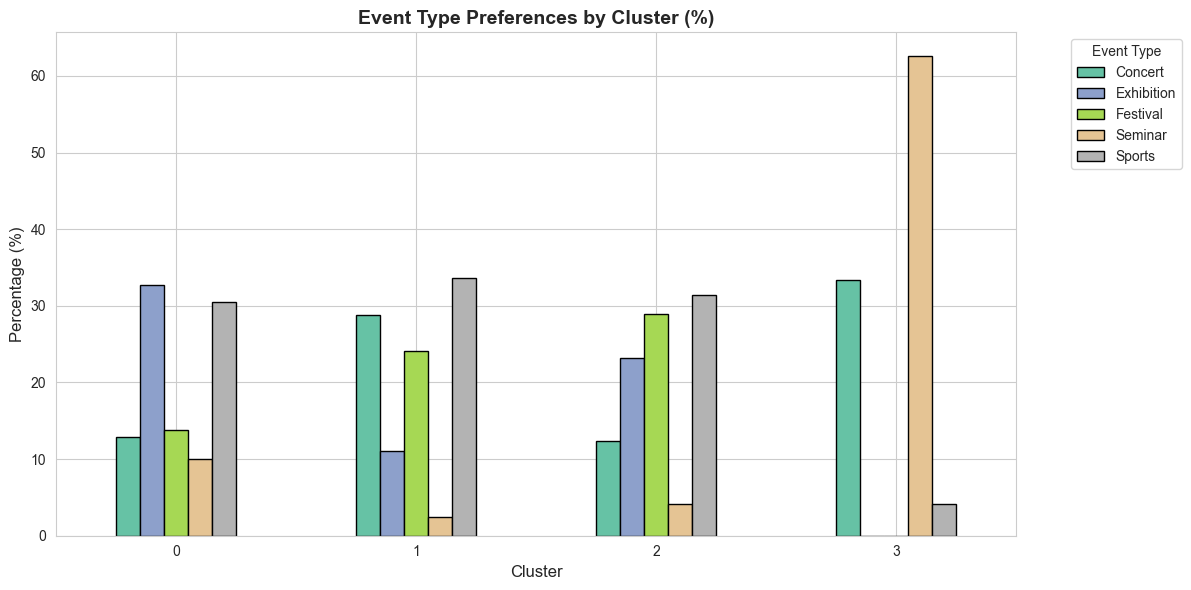

In [6]:
# ============================================================================
# 6. CLUSTERING ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("CLUSTERING ANALYSIS (K-MEANS)")
print("=" * 80)

# Prepare features for clustering
clustering_features = ['Income', 'Ticket_Price', 'Affordability_Index', 'Age']
X_cluster = df[clustering_features].copy()

# Standardize features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Elbow method to find optimal k
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.savefig('05_elbow_method.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 05_elbow_method.png")
plt.show()

# Apply K-Means with optimal k (let's use k=4)
optimal_k = 4
print(f"\nApplying K-Means with k={optimal_k}...")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

print(f"✓ Clustering complete!")
print("\nCluster Distribution:")
print(df['Cluster'].value_counts().sort_index())

# Analyze clusters
print("\nCluster Characteristics:")
cluster_analysis = df.groupby('Cluster')[['Income', 'Ticket_Price', 'Affordability_Index', 'Age', 'Attendance']].mean()
print(cluster_analysis.round(2))

# Visualize clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Income vs Ticket Price
scatter1 = axes[0].scatter(df['Income'], df['Ticket_Price'],
                          c=df['Cluster'], cmap='viridis',
                          alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Income ($)', fontsize=12)
axes[0].set_ylabel('Ticket Price ($)', fontsize=12)
axes[0].set_title('Clusters: Income vs Ticket Price', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Affordability Index vs Age
scatter2 = axes[1].scatter(df['Age'], df['Affordability_Index'],
                          c=df['Cluster'], cmap='viridis',
                          alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Age', fontsize=12)
axes[1].set_ylabel('Affordability Index', fontsize=12)
axes[1].set_title('Clusters: Age vs Affordability Index', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.savefig('06_cluster_visualization.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 06_cluster_visualization.png")
plt.show()

# Cluster event preferences
print("\nEvent Type Preferences by Cluster:")
cluster_event_pref = pd.crosstab(df['Cluster'], df['Event_Type'], normalize='index') * 100
print(cluster_event_pref.round(1))

cluster_event_pref.plot(kind='bar', figsize=(12, 6), colormap='Set2', edgecolor='black')
plt.title('Event Type Preferences by Cluster (%)', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('07_cluster_event_preferences.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 07_cluster_event_preferences.png")
plt.show()




CLASSIFICATION MODEL - PREDICTING ATTENDANCE

Training set: 800 samples
Test set: 200 samples

--------------------------------------------------------------------------------
Model 1: Logistic Regression
--------------------------------------------------------------------------------

Accuracy: 0.9050
Precision: 0.9091
Recall: 0.9945

Classification Report:
                precision    recall  f1-score   support

Did Not Attend       0.50      0.05      0.10        19
      Attended       0.91      0.99      0.95       181

      accuracy                           0.91       200
     macro avg       0.70      0.52      0.52       200
  weighted avg       0.87      0.91      0.87       200


--------------------------------------------------------------------------------
Model 2: Decision Tree Classifier
--------------------------------------------------------------------------------

Accuracy: 0.8850
Precision: 0.9072
Recall: 0.9724

Classification Report:
                precision  

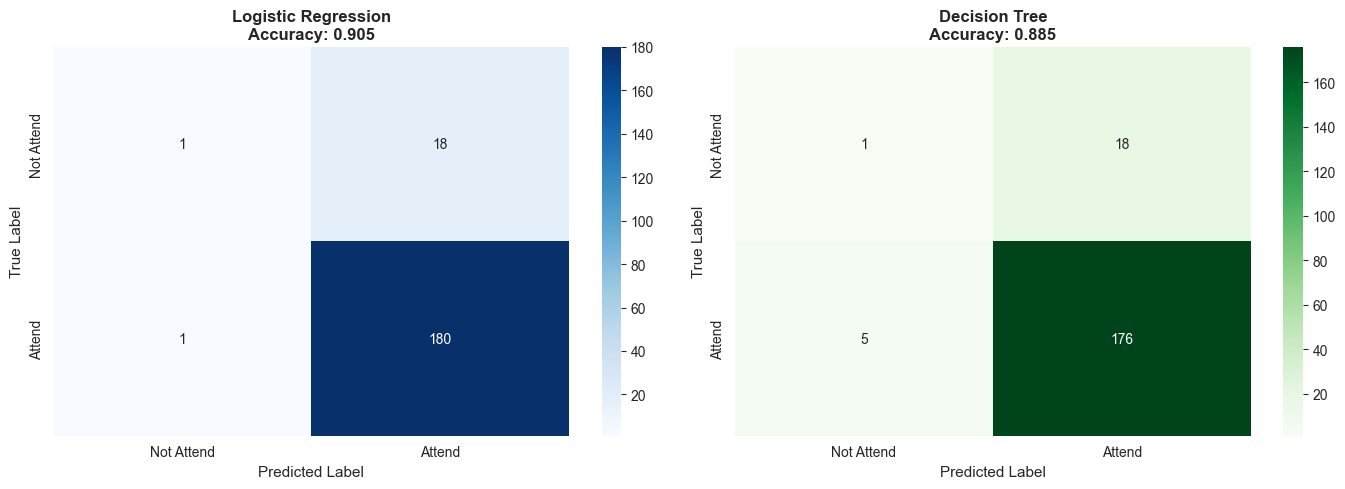

✓ Saved: 09_feature_importance.png


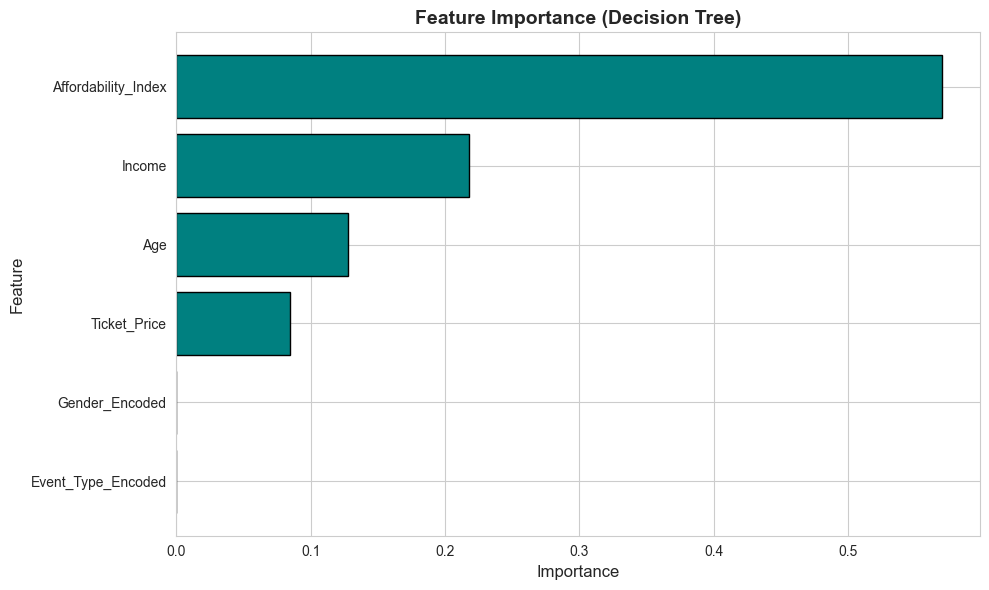

In [7]:
# ============================================================================
# 7. CLASSIFICATION MODEL
# ============================================================================

print("\n" + "=" * 80)
print("CLASSIFICATION MODEL - PREDICTING ATTENDANCE")
print("=" * 80)

# Prepare features for classification
classification_features = ['Age', 'Income', 'Ticket_Price', 'Affordability_Index',
                          'Gender_Encoded', 'Event_Type_Encoded']
X = df[classification_features]
y = df['Attendance']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Model 1: Logistic Regression
print("\n" + "-" * 80)
print("Model 1: Logistic Regression")
print("-" * 80)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)

print(f"\nAccuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred, target_names=['Did Not Attend', 'Attended']))

# Model 2: Decision Tree
print("\n" + "-" * 80)
print("Model 2: Decision Tree Classifier")
print("-" * 80)

dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)

print(f"\nAccuracy: {dt_accuracy:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall: {dt_recall:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, dt_pred, target_names=['Did Not Attend', 'Attended']))

# Feature importance (Decision Tree)
feature_importance = pd.DataFrame({
    'Feature': classification_features,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Decision Tree):")
print(feature_importance)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression confusion matrix
cm_lr = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Attend', 'Attend'], yticklabels=['Not Attend', 'Attend'])
axes[0].set_title(f'Logistic Regression\nAccuracy: {lr_accuracy:.3f}', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)

# Decision Tree confusion matrix
cm_dt = confusion_matrix(y_test, dt_pred)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Not Attend', 'Attend'], yticklabels=['Not Attend', 'Attend'])
axes[1].set_title(f'Decision Tree\nAccuracy: {dt_accuracy:.3f}', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.savefig('08_confusion_matrices.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 08_confusion_matrices.png")
plt.show()

# Feature importance plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='teal', edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance (Decision Tree)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('09_feature_importance.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 09_feature_importance.png")
plt.show()




INSIGHTS & RECOMMENDATIONS

--------------------------------------------------------------------------------
Event Preferences by Budget Category
--------------------------------------------------------------------------------

Percentage distribution:
Event_Type       Concert  Exhibition  Festival  Seminar  Sports
Budget_Category                                                
Low                 22.4        16.4      16.1     17.3    27.9
Medium              22.9        17.6      16.5     16.2    26.8
High                21.2        19.7      16.7     17.6    24.8

✓ Saved: 10_budget_event_preferences.png


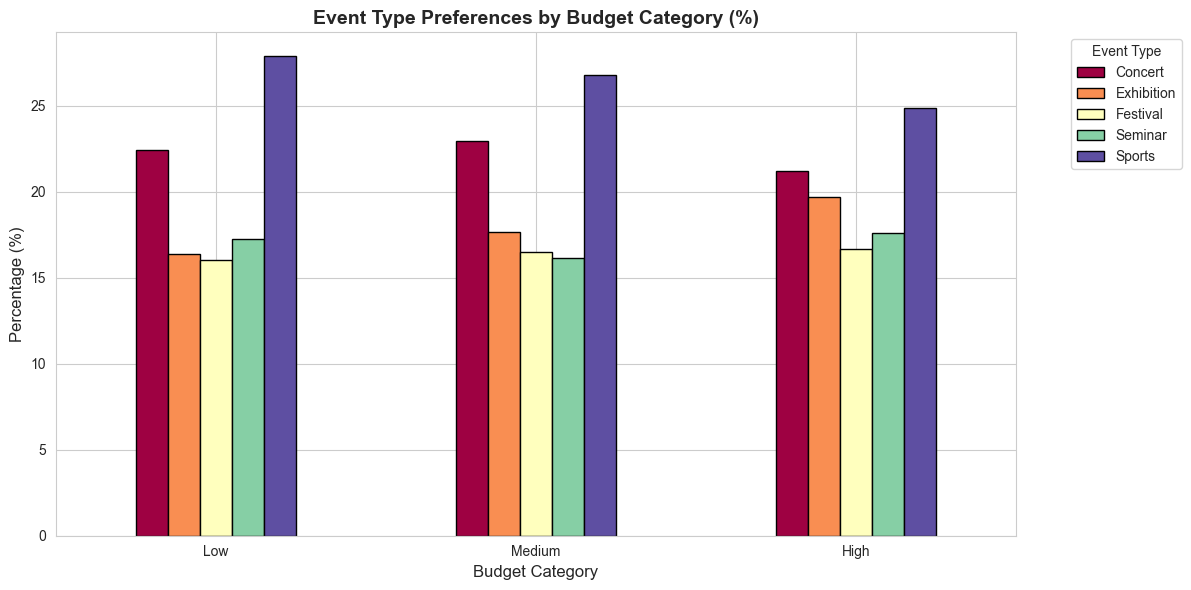


--------------------------------------------------------------------------------
Attendance Rates by Budget Category
--------------------------------------------------------------------------------

Attendance rate (%):
                      mean  count
Budget_Category                  
Low              82.424242    330
Medium           91.764706    340
High             97.878788    330

--------------------------------------------------------------------------------
Average Metrics by Budget Category
--------------------------------------------------------------------------------
                   Income  Ticket_Price  Affordability_Index  Attendance
Budget_Category                                                         
Low              22531.02        109.29               283.34        0.82
Medium           37429.39        106.33               471.14        0.92
High             74710.21        110.21               924.17        0.98

KEY FINDINGS

1. CUSTOMER SEGMENTATION (Clust

In [8]:
# ============================================================================
# 8. INSIGHTS & RECOMMENDATIONS
# ============================================================================

print("\n" + "=" * 80)
print("INSIGHTS & RECOMMENDATIONS")
print("=" * 80)

# Analyze budget categories and event preferences
print("\n" + "-" * 80)
print("Event Preferences by Budget Category")
print("-" * 80)

budget_event_analysis = pd.crosstab(df['Budget_Category'], df['Event_Type'], normalize='index') * 100
print("\nPercentage distribution:")
print(budget_event_analysis.round(1))

budget_event_analysis.plot(kind='bar', figsize=(12, 6), colormap='Spectral', edgecolor='black')
plt.title('Event Type Preferences by Budget Category (%)', fontsize=14, fontweight='bold')
plt.xlabel('Budget Category', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('10_budget_event_preferences.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 10_budget_event_preferences.png")
plt.show()

# Attendance rates by budget category
print("\n" + "-" * 80)
print("Attendance Rates by Budget Category")
print("-" * 80)

attendance_by_budget = df.groupby('Budget_Category')['Attendance'].agg(['mean', 'count'])
attendance_by_budget['mean'] = attendance_by_budget['mean'] * 100
print("\nAttendance rate (%):")
print(attendance_by_budget)

# Average affordability index by budget category
print("\n" + "-" * 80)
print("Average Metrics by Budget Category")
print("-" * 80)

budget_metrics = df.groupby('Budget_Category')[['Income', 'Ticket_Price', 'Affordability_Index', 'Attendance']].mean()
print(budget_metrics.round(2))

# Generate final insights
print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)

# Finding 1: Cluster characteristics
print("\n1. CUSTOMER SEGMENTATION (Clusters):")
for cluster_id in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster_id]
    avg_income = cluster_data['Income'].mean()
    avg_price = cluster_data['Ticket_Price'].mean()
    avg_afford = cluster_data['Affordability_Index'].mean()
    attendance_rate = cluster_data['Attendance'].mean() * 100
    top_event = cluster_data['Event_Type'].mode()[0]

    print(f"\n   Cluster {cluster_id}:")
    print(f"   - Average Income: ${avg_income:,.0f}")
    print(f"   - Average Ticket Price: ${avg_price:.2f}")
    print(f"   - Affordability Index: {avg_afford:.1f}")
    print(f"   - Attendance Rate: {attendance_rate:.1f}%")
    print(f"   - Most Popular Event: {top_event}")

# Finding 2: Budget category preferences
print("\n2. BUDGET CATEGORY INSIGHTS:")
for budget_cat in ['Low', 'Medium', 'High']:
    budget_data = df[df['Budget_Category'] == budget_cat]
    if len(budget_data) == 0:
        continue

    top_events = budget_data['Event_Type'].value_counts().head(2)
    attendance_rate = budget_data['Attendance'].mean() * 100
    avg_income = budget_data['Income'].mean()

    print(f"\n   {budget_cat} Budget Segment:")
    print(f"   - Average Income: ${avg_income:,.0f}")
    print(f"   - Attendance Rate: {attendance_rate:.1f}%")
    print(f"   - Top Events: {', '.join([f'{event} ({count})' for event, count in top_events.items()])}")

# Finding 3: Model performance
print("\n3. PREDICTIVE MODEL PERFORMANCE:")
print(f"\n   - Logistic Regression Accuracy: {lr_accuracy:.1%}")
print(f"   - Decision Tree Accuracy: {dt_accuracy:.1%}")
print(f"   - Most Important Factor: {feature_importance.iloc[0]['Feature']}")

print("\n" + "=" * 80)
print("STRATEGIC RECOMMENDATIONS")
print("=" * 80)

recommendations = """
Based on the analysis, here are data-driven recommendations for event organizers:

1. LOW BUDGET SEGMENT ($0 - ~$40K income):
   → Target with: Festivals, Community Events, Budget Sports Events
   → Price Range: $20 - $60
   → Strategy: Focus on volume, group discounts, early bird pricing
   → Marketing: Social media, word-of-mouth, community partnerships

2. MEDIUM BUDGET SEGMENT (~$40K - ~$60K income):
   → Target with: Concerts, Sports Events, Exhibitions
   → Price Range: $50 - $120
   → Strategy: Tiered pricing, loyalty programs, package deals
   → Marketing: Email campaigns, targeted digital ads, influencer partnerships

3. HIGH BUDGET SEGMENT ($60K+ income):
   → Target with: Premium Seminars, Exclusive Exhibitions, VIP Concerts
   → Price Range: $100 - $300+
   → Strategy: Premium experiences, VIP packages, networking opportunities
   → Marketing: Professional networks, executive channels, direct outreach

4. AGE-BASED TARGETING:
   → 18-30: Concerts, Festivals (high energy, social experiences)
   → 31-45: Sports, Mix of Events (family-friendly, diverse interests)
   → 46-65: Seminars, Exhibitions (educational, professional development)

5. PRICING OPTIMIZATION:
   → Monitor Affordability Index (Income/Ticket_Price ratio)
   → Optimal ratio appears to be 200-500 for maximum attendance
   → Below 100: High risk of low attendance
   → Above 1000: Consider premium positioning

6. ATTENDANCE DRIVERS:
   → Primary Factor: Affordability Index (Income vs Price)
   → Secondary: Event Type alignment with demographics
   → Tertiary: Age and life stage considerations

7. OPERATIONAL RECOMMENDATIONS:
   → Implement dynamic pricing based on demand segments
   → Create multi-tier ticket options for each event type
   → Develop targeted marketing campaigns per budget segment
   → Use predictive models to forecast attendance and optimize inventory
   → Build loyalty programs to increase repeat attendance
"""

print(recommendations)

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
print("\nAll visualizations saved:")
print("  ✓ 01_data_distributions.png")
print("  ✓ 02_demographics.png")
print("  ✓ 03_income_vs_price.png")
print("  ✓ 04_event_by_age.png")
print("  ✓ 05_elbow_method.png")
print("  ✓ 06_cluster_visualization.png")
print("  ✓ 07_cluster_event_preferences.png")
print("  ✓ 08_confusion_matrices.png")
print("  ✓ 09_feature_importance.png")
print("  ✓ 10_budget_event_preferences.png")

print("\nDataset saved for further analysis:")
df.to_csv('event_affordability_dataset.csv', index=False)
print("  ✓ event_affordability_dataset.csv")

print("\n" + "=" * 80)
print("Thank you for using the Event Affordability Analysis!")
print("=" * 80)
